# JUNIQ Tutorial - Optimizing Pokemon Teams

In this tutorial, we will learn how the quantum computer JUPSI works and how we can use it to find optimal Pokemon teams.

This tutorial is meant for school students and was inspired by work from [Kuklinski and Gottlieb](https://www.youtube.com/watch?v=CSLm1HrY6UE).

In [1]:
# first, to make this tutorial work, we need to execute this cell to load the following packages
from dwave.system import DWaveSampler, EmbeddingComposite
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# we will connect to the quantum annealer JUPSI via the variable "jupsi"
jupsi = EmbeddingComposite(DWaveSampler(region='eu-central-1'))

# Introduction

JUPSI solves Quadratic Unconstrained Binary Optimization (QUBO) problems.

What does this mean?

1. **Optimization**: JUPSI finds the **minimum** of a **cost function**:
```
min( ... q0 ... q1 ... q2 ... q0*q1 ... )

     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
               cost function
```

2. **Binary**: In the cost function, there are the qubits. JUPSI finds binary values (0 or 1) for each of the qubits. For example:
```
q0 = 0
q1 = 0
q2 = 1
q3 = 1
q4 = 1
q5 = 0
```

3. **Quadratic**: In the cost function, products between the qubits cannot be more complicated than quadratic. `q0*q1` is quadratic, just as `x*x` is quadratic.
```
This is a QUBO:     min( q0 + q1 - q2 - q0*q1 + ... )
This is not a QUBO: min( q0 + q1 - q2 - q0*q1*q2 + ... )
```

## Examples

**Example 1**
```
min( q0 + q1 )
```
What is the minimum?
```
q0 = 0
q1 = 0

    => q0 + q1 = 0
```

**Example 2**
```
min( q0 - q1 + q2 )
```
What is the minimum?
```
q0 = 0
q1 = 1
q2 = 0

    => q0 - q1 + q2 = -1
```

**Example 3**
```
min( - q0*q1 )
```
What is the minimum?
```
q0 = 1
q1 = 1

    => - q0*q1 = -1
```

**Example 4**
```
min( 3*q0 - 2*q1 - 5*q0*q1 )
```
What is the minimum?
```
q0 = 1
q1 = 1

    => 3*q0 - 2*q1 - 5*q0*q1 = -4
```
Problems like these can quickly become very difficult.

**A quantum annealer like JUPSI was made to solve exactly such problems.**

To solve **Example 4** on JUPSI, we must translate the equation into something that Python can understand. We use a dictionary to achieve this. Just follow these steps.

1. Identifiy the numbers in the QUBO equation. Here we have 3, -2, -5.

```
Q = {
    3,
    -2,
    -5
}
```

2. But this does not tell JUPSI which number belongs to which qubits. -5 belongs to qubits 0 and 1: q0*q1. We do this using this notation

```
(0, 1): -5
```

3. The numbers that belong to a single qubit need to have the same form. We write the numbers twice.

```
(0, 0): 3,
(1, 1): -2
```

The result looks like the following code snippet. This is a full quantum computer program!

In [3]:
Q = {
    (0, 0): 3,
    (1, 1): -2,
    (0, 1): -5,
}
result = jupsi.sample_qubo(Q)
result.to_pandas_dataframe()

,0,1,chain_break_fraction,energy,num_occurrences
0,1,1,0.0,-4.0,1


So the minimum is:

```
q0 = 1
q1 = 1

    => energy = 3*q0 - 2*q1 - 5*q0*q1 = -4
```

The number `-4` at the minimum is called the `energy` of the QUBO.

### <font size="4"><span style='background:yellow'>**Exercise 1**</span></font>

Solve the following QUBO problem on JUPSI! Just use the same three-step procedure from before.

```
min( - 3*q0 - 2*q1 + 4*q2 + 5*q3 - 4*q0*q1 + 7*q1*q2 - 3*q0*q2 )
```
What is the minimum?

What is the energy at the minimum?

In [4]:
Q = {
    # Complete this quantum computer program by specifying the problem here, like we did in Example 4
    
}
result = jupsi.sample_qubo(Q)
result.to_pandas_dataframe()

,chain_break_fraction,energy,num_occurrences


A quantum annealer looks not only for the solution with **minimum energy**, but also for other solutions with **low energy**.

If there are more than one solution, we can find them by asking for more **reads** (= number of quantum computing runs):

```
num_reads = 1000
```

**Example 5**

```
min( - 2*q0*q1 + 2*q0*q2 - 2*q0*q3 + 2*q1*q2 + 2*q1*q3 )
```

In [5]:
Q = {
    (0, 1): -2,
    (0, 2): 2,
    (0, 3): -2,
    (1, 2): 2,
    (1, 3): 2,
}
result = jupsi.sample_qubo(Q, num_reads=1000)
result.to_pandas_dataframe()

,0,1,2,3,chain_break_fraction,energy,num_occurrences
0,1,1,0,1,0.0,-2.0,371
1,1,0,0,1,0.0,-2.0,292
2,1,1,0,0,0.0,-2.0,337


**Questions:** 

1. How many solutions did you find?

2. Do they all have the same energy?

### <font size="4"><span style='background:yellow'>**Exercise 2**</span></font>

Try to add some arbitrary terms to the QUBO and solve it on JUPSI!

**Questions:** What do you observe? Do all solutions always have the same energy?

In [6]:
# Write your quantum computer program here:



**Hint:** JUPSI cannot only find the minimum energy, but also close-to-optimal solutions with a slightly higher energy. The more terms the QUBO has, the more likely it is to find close-to-optimal solutions.

# <a class="anchor" id="setup"> </a>Optimizing Pokemon Teams

To find a good Pokemon team, we will represent each Pokemon type (PT) by a qubit `qType`.

- If the qubit is `qType = 1`, we will take a Pokemon of this type into our team
- If the qubit is `qType = 0`, we won't

This map shows which Pokemon type is strong (green) or weak (red) against another Pokemon type.

**Example**: Water (row 3) is strong against Fire (column 2) but weak against Water (column 3) and Grass (column 4)

<div align="left">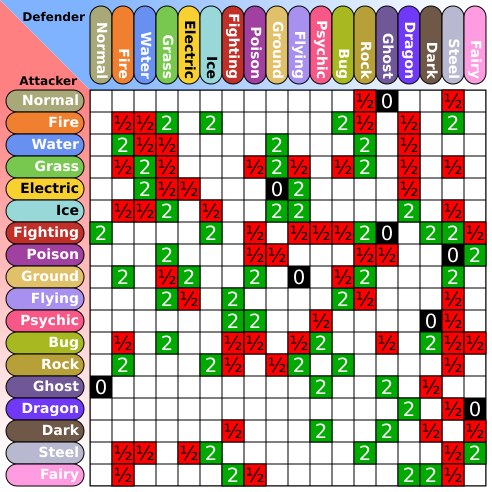</div>

## **Cost Function**

For now, we only consider Fire, Water, Grass, Electric, Ice, and Fighting.

To find an optimal Pokemon team, we consider three choices for the cost function:

1. **Offensive**: For each attacking type (row), we count -1 for a strong attack (green item in a row) and +1 for a weak attack (red item in a row).
```
    min( 0*qFire + 1*qWater + 1*qGrass + 1*qElectric + 2*qIce - 2*qFighting )
```

2. **Defensive**: For each defending type (column), we count -1 for a weak attack (red item in a column) and +1 for a strong attack (green item in a column).
```
    min( - 2*qFire - 1*qWater - 1*qGrass - 1*qElectric + 1*qIce + 0*qFighting )
```

3. **Balanced**: For each defending type, we sum up the offensive cost (1.) and the defensive cost (2.)
```
    min( - 2*qFire + 0*qWater + 0*qGrass + 0*qElectric + 3*qIce - 2*qFighting )
```

First, we optimize for an offensive team. Note that we do not need to label the qubits `0`, `1`, `2`, ... but we can also call them `'Fire'`, `'Water'`, etc.

In [7]:
Q = {
    ('Fire', 'Fire'):          0,
    ('Water', 'Water'):        1,
    ('Grass', 'Grass'):        1,
    ('Electric', 'Electric'):  1,
    ('Ice', 'Ice'):            2,
    ('Fighting', 'Fighting'): -2,
}
result = jupsi.sample_qubo(Q, num_reads=100)
result.to_pandas_dataframe()

,Electric,Fighting,Fire,Grass,Ice,Water,chain_break_fraction,energy,num_occurrences
0,0,1,0,0,0,0,0.0,-2.0,62
1,0,1,1,0,0,0,0.0,-2.0,38


### <font size="4"><span style='background:yellow'>**Exercise 3**</span></font>

Try to optimize a **balanced** Pokemon team!

**Question:** Does the result make sense?

In [8]:
# Write your quantum computer program here:



### <font size="4"><span style='background:yellow'>**Exercise 4**</span></font>

Try to optimize a **defensive** Pokemon team!

In [9]:
# Write your quantum computer program here:



### <font size="4"><span style='background:yellow'>**Bonus Exercise 4**</span></font>

Consider not only 6 Pokemon types, but all 18 Pokemon types!

**Question**: For a defensive team, a damage multiplier of 0 (black item in a column) is even better. How should this be reflected in the cost function?

In [10]:
# Write your quantum computer program here:



## Constraints

Let's look again at

**Example 5**

```
min( - 2*q0*q1 + 2*q0*q2 - 2*q0*q3 + 2*q1*q2 + 2*q1*q3 )
```

In [11]:
Q = {
    (0, 1): -2,
    (0, 2): 2,
    (0, 3): -2,
    (1, 2): 2,
    (1, 3): 2,
}
result = jupsi.sample_qubo(Q, num_reads=1000)
result.to_pandas_dataframe()

,0,1,2,3,chain_break_fraction,energy,num_occurrences
0,1,0,0,1,0.0,-2.0,293
1,1,1,0,0,0.0,-2.0,356
2,1,1,0,1,0.0,-2.0,351


There were three solutions in **Example 5**
- `1 0 0 1` (two qubits are 1)
- `1 1 0 0` (two qubits are 1)
- `1 1 0 1` (three qubits are 1)

If we only want solutions where two qubits are 1,
```
q0 + q1 + q2 + q3 == 2
```
we can add a **constraint** to the QUBO:
```
(q0 + q1 + q2 + q3 - 2)²
```
This QUBO term will only be minimal if two qubits are 1. 

To add this term, we have to multiply it out to compute the numbers before the qubits:
```
(q0 + q1 + q2 + q3 - 2)² = (q0 + q1 + q2 + q3 - 2)*(q0 + q1 + q2 + q3 - 2)
                         = q0*q0 + q0*q1 + q0*q2 + q0*q3 - 2*q0
                         + q1*q0 + q1*q1 + q1*q2 + q1*q3 - 2*q1
                         + q2*q0 + q2*q1 + q2*q2 + q2*q3 - 2*q2
                         + q3*q0 + q3*q1 + q3*q2 + q3*q3 - 2*q3
                                                         - 2*q0 - 2*q1 - 2*q2 - 2*q3
                                                         + 4
```

This QUBO has a lot of terms. But we can simplify it if we use the following tricks:
- `q0*q0 = q0` because `q0` can only be either `0` or `1`, and `0*0 = 0` and `1*1 = 1`
- `q1*q0 = q0*q1`
- The constant number `4` can be left out, because it will not change the minimum (only the energy)

Therefore, we find the following constraint QUBO:
```
CONSTRAINT: min( - 3*q0 - 3*q1 - 3*q2 - 3*q3 + 2*q0*q1 + 2*q0*q2 + 2*q0*q3 + 2*q1*q2 + 2*q1*q3 + 2*q2*q3 )
```

We add this to the QUBO from **Example 5**
```
QUBO: min( - 2*q0*q1 + 2*q0*q2 - 2*q0*q3 + 2*q1*q2 + 2*q1*q3 )
```

Our final QUBO then becomes:

**Example 6**:
```
QUBO: min( - 3*q0 - 3*q1 - 3*q2 - 3*q3 + 4*q0*q2 + 4*q1*q2 + 4*q1*q3 + 2*q2*q3 )
```

In [12]:
Q = {
    (0, 0): -3,
    (1, 1): -3,
    (2, 2): -3,
    (3, 3): -3,
    (0, 2): 4,
    (1, 2): 4,
    (1, 3): 4,
    (2, 3): 2,
}
result = jupsi.sample_qubo(Q, num_reads=100)
result.to_pandas_dataframe()

,0,1,2,3,chain_break_fraction,energy,num_occurrences
0,1,0,0,1,0.0,-6.0,56
1,1,1,0,0,0.0,-6.0,43
2,0,0,0,1,0.0,-3.0,1


**Note for advanced users:** 

When we add constraints to QUBOs, we usually need an additional multiplier (called "Lagrange multiplier") between the cost function and the constraints, to make sure that the minimum is really the correct minimum. It takes the form
```
min( COSTFUNCTION + lagrange*CONSTRAINT )
```
However, for simplicity, in this notebook, we do not consider tuning the Lagrange multipliers, so we simply set `lagrange = 1`.

### <font size="4"><span style='background:yellow'>**Exercise 5**</span></font>

Try to do the same, but for the constraint where three qubits are 1.
```
q0 + q1 + q2 + q3 == 3
```

**Hint:** The QUBO is very similar. If you look closely at what happens to the `2` in `(q0 + q1 + q2 + q3 - 2)²`, you might be able to guess what would happen to a `3` there.

In [13]:
# Write your quantum computer program here:



**Note for advanced users:** 

The general QUBO formula for a constraint `q0 + q1 + q2 + ... == s` reads
```
CONSTRAINT: min( - (2s-1)*q0 - (2s-1)*q1 - (2s-1)*q2 - ...
                 + 2*q0*q1 + 2*q0*q2 + 2*q0*q3 + ... 
                           + 2*q1*q2 + 2*q1*q3 + ... 
                                     + 2*q2*q3 + ... )
```
or, using the sum notation:
$$
\sum_{i=0}^{n-1} -(2s-1) q_i + \sum_{i=0}^{n-1}\sum_{j=i+1}^{n-1} 2 q_i q_j
$$
In Python, we could use the following `for` loops to add all these terms to a QUBO `Q`:
```python
for i in range(n):
    Q[(i, i)] += -(2*s - 1)
for i in range(n):
    for j in range(i+1, n):
        Q[(i, j)] += 2
```
Note that `n` and `s` must exist. Additionally, it is good to define the QUBO not as `Q = {}` but as `Q = defaultdict(float)` because this will add `(i, j): 0` automatically to `Q` even if it does not yet exist in `Q`.

## Constraint: Team Size

A Pokemon team should not be arbitrarily large.

Therefore, we now add the constraint that there shall be exactly 3 Pokemon in our team (note: In a normal Pokemon team, there are usually 6 Pokemon).

This means that we want
```
qFire + qWater + qGrass + qElectric + qIce + qFighting == 3
```

To do this, we have to add the following to the QUBO:
```
(qFire + qWater + qGrass + qElectric + qIce + qFighting - 3)² 
```

Using the result from **Exercise 3**, this will give the following terms:
```
    - 5*qFire - 5*qWater - 5*qGrass - 5*qElectric - 5*qIce - 5*qFighting 
    + 2*qFire*qWater + 2*qFire*qGrass  + 2*qFire*qElectric + ...
                     + 2*qWater*qGrass + 2*qWater*qElectric + ...
                                       + 2*qGrass*qElectric + ...
                                                            + ...
```

We start by doing this for the **balanced** team:

In [14]:
Q = {
    ('Fire', 'Fire'):         -2 - 5,
    ('Water', 'Water'):        0 - 5,
    ('Grass', 'Grass'):        0 - 5,
    ('Electric', 'Electric'):  0 - 5,
    ('Ice', 'Ice'):            3 - 5,
    ('Fighting', 'Fighting'): -2 - 5,
    ('Fire', 'Water'):         2,
    ('Fire', 'Grass'):         2,
    ('Fire', 'Electric'):      2,
    ('Fire', 'Ice'):           2,
    ('Fire', 'Fighting'):      2,
    ('Water', 'Grass'):        2,
    ('Water', 'Electric'):     2,
    ('Water', 'Ice'):          2,
    ('Water', 'Fighting'):     2,
    ('Grass', 'Electric'):     2,
    ('Grass', 'Ice'):          2,
    ('Grass', 'Fighting'):     2,
    ('Electric', 'Ice'):       2,
    ('Electric', 'Fighting'):  2,
    ('Ice', 'Fighting'):       2,
}
result = jupsi.sample_qubo(Q, num_reads=1000)
result.to_pandas_dataframe()

,Electric,Fighting,Fire,Grass,Ice,Water,chain_break_fraction,energy,num_occurrences
0,1,1,1,0,0,0,0.000000,-13.0,310
1,0,1,1,0,0,1,0.000000,-13.0,333
2,0,1,1,1,0,0,0.000000,-13.0,278
3,0,1,1,1,0,1,0.000000,-12.0,13
4,1,1,1,1,0,0,0.000000,-12.0,23
5,0,1,1,0,0,0,0.000000,-12.0,16
6,1,1,1,0,0,1,0.000000,-12.0,17
7,0,1,1,1,0,1,0.166667,-12.0,2
8,1,1,0,0,0,1,0.000000,-11.0,1
9,1,0,1,1,0,0,0.000000,-11.0,2


**Question**: Does the result make sense? Look again at the cost function in the QUBO:
```
    min( - 2*qFire + 0*qWater + 0*qGrass + 0*qElectric + 3*qIce - 2*qFighting )
```

### <font size="4"><span style='background:yellow'>**Exercise 6**</span></font>

Try to optimize a **defensive** Pokemon team with 4 Pokemon!

In [15]:
# Write your quantum computer program here:



### <font size="4"><span style='background:yellow'>**Bonus Exercise 6**</span></font>

Also here, if you want, you can optimize over all 18 Pokemon types. Furthermore, you can try to optimize a team with 6 Pokemon.

In [16]:
# Write your quantum computer program here:



# **Advanced** 

This section contains further code snippets for advanced users.

## General QUBO

<div align="center">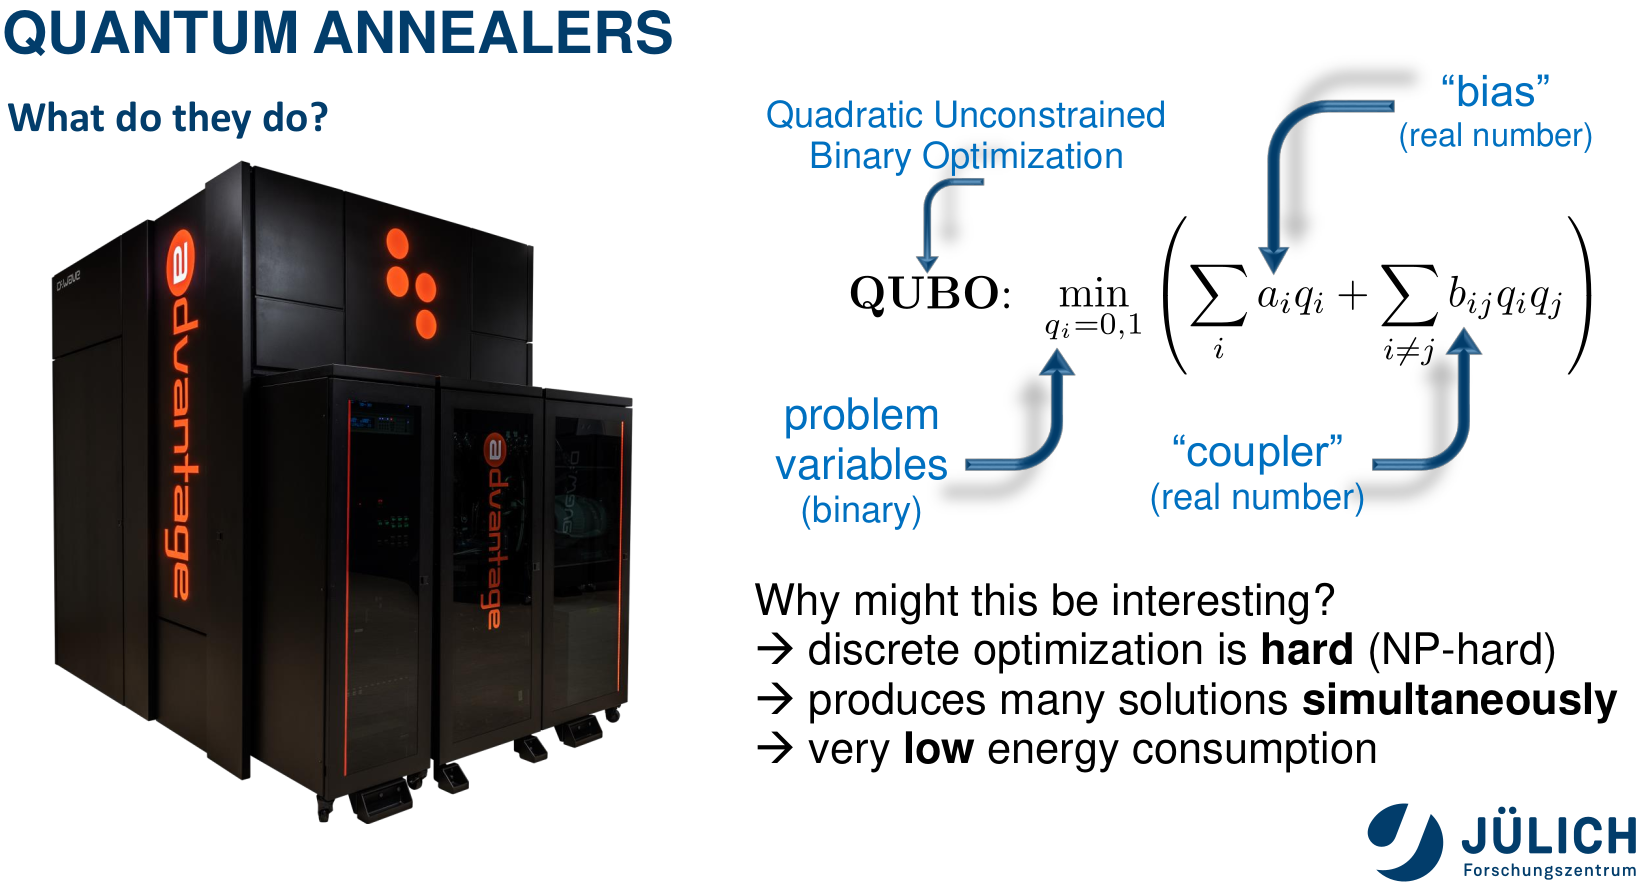</div>

## **The QUBO Matrix**

A good way to visualize larger problems is to build and plot the QUBO matrix (also known as "Hamilton matrix").

In the QUBO matrix, every term in the QUBO of the form 
```
    (i, j): Qij
```
will appear in row `i` and column `j` (where we always require `i<j`, otherwise we simply swap `i` and `j`)

For example, the QUBO matrix for the QUBO from Exercise 1
```
min( - 3*q0 - 2*q1 + 4*q2 + 5*q3 - 4*q0*q1 + 7*q1*q2 - 3*q0*q2 )
```
looks like this:
```
/ -3 -4 -3  0 \
| 0  -2  7  0 |
| 0   0  4  0 |
\ 0   0  0  5 /
```

In [17]:
# you can use the following function to plot this matrix
def plot_qubo_matrix(Q, figsize=(6,5)):
    seen = set()
    keys = [key for key in sum(map(list,Q), start=[]) if not (key in seen or seen.add(key))]
    Q = {(keys.index(keyi), keys.index(keyj)): Q[keyi,keyj] for keyi,keyj in Q}
    dim = max(max(i,j) for i,j in Q) + 1
    Qmatrix = np.zeros((dim,dim))
    for (i,j),Qij in Q.items():
        if i > j:  # aggregate terms in the upper triangle
            i,j = j,i
        Qmatrix[i,j] += Qij
    plt.figure(figsize=figsize)
    plt.imshow(Qmatrix, cmap='Spectral')
    for i in range(dim):
        for j in range(i,dim):
            plt.text(j, i, f'{Qmatrix[i,j]:.2f}', ha='center', va='center')
    Qmax = np.max(np.abs(Qmatrix))
    plt.clim((-Qmax,Qmax))
    plt.colorbar()
    plt.xticks(range(dim), keys)
    plt.yticks(range(dim), keys)
    plt.show()

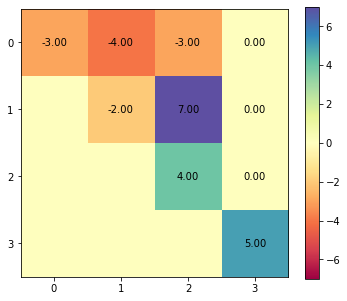

In [18]:
Q = {
    (0,0): -3,
    (1,1): -2,
    (2,2): 4,
    (3,3): 5,
    (0,1): -4,
    (1,2): 7,
    (0,2): -3,
}

plot_qubo_matrix(Q)

## Generic Equality Constraints

The following code shows how to optimize an **offensive** Pokemon team with 6 Pokemon over all Pokemon types.

The constraint with 6 Pokemon
```
qFire + qWater + qGrass + ... == 6
```
will be added generically using `for` loops.

<div align="left">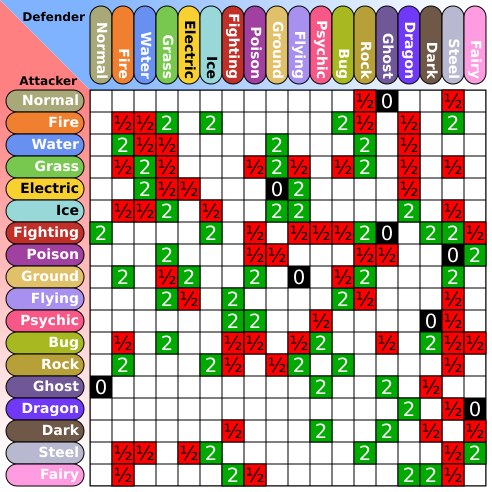</div>

In [19]:
types = ['Normal', 'Fire', 'Water', 'Grass', 'Electric', 'Ice', 'Fighting', 'Poison', 'Ground', 'Flying', 'Psychic', 'Bug', 'Rock', 'Ghost', 'Dragon', 'Dark', 'Steel', 'Fairy']

# we define Q as defaultdict(float) instead of simply {}; this will always add `(i, j): 0.0` automatically to `Q` if `(i, j)` it does not yet exist in `Q`.
from collections import defaultdict
Q = defaultdict(float)

# add the terms of the cost function to the QUBO
Q[('Normal', 'Normal')]     =  4  # we consider a "0" as "even worse" and add a double penalty of +2
Q[('Fire', 'Fire')]         =  0
Q[('Water', 'Water')]       =  0
Q[('Grass', 'Grass')]       =  4
Q[('Electric', 'Electric')] =  3
Q[('Ice', 'Ice')]           =  0
Q[('Fighting', 'Fighting')] =  2
Q[('Poison', 'Poison')]     =  4
Q[('Ground', 'Ground')]     = -1
Q[('Flying', 'Flying')]     =  0
Q[('Psychic', 'Psychic')]   =  2
Q[('Bug', 'Bug')]           =  4
Q[('Rock', 'Rock')]         = -1
Q[('Ghost', 'Ghost')]       =  1
Q[('Dragon', 'Dragon')]     =  2
Q[('Dark', 'Dark')]         =  1
Q[('Steel', 'Steel')]       =  1
Q[('Fairy', 'Fairy')]       =  0

# add the constraints
for t in types:
    Q[(t, t)] += -(2*6 - 1)
for i in range(len(types)):
    for j in range(i+1, len(types)):
        Q[(types[i], types[j])] += 2

# solve the problem on the quantum annealer
result = jupsi.sample_qubo(Q, num_reads=100)
result.to_pandas_dataframe()[types+['energy','num_occurrences']]  # this indexing sorts the columns; furthermore, we do not display the column 'chain break fraction' to show the table in full width

,Normal,Fire,Water,Grass,Electric,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy,energy,num_occurrences
0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,-38.0,1
1,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,-38.0,1
2,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,-38.0,1
3,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,-38.0,2
4,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,-38.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,-31.0,1
79,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,1,1,-31.0,1
80,0,1,0,0,0,1,0,0,1,1,1,0,1,0,0,1,0,0,-34.0,1
81,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,-34.0,1


The solution makes sense if all Pokemon with negative cost are on the team, and all with zero cost occur equally likely.

## Inequality Constraint: Diversity

Against every attacking type, we want fewer than two weak Pokemon on our team.

For example, against Fire, the types Grass, Ice, and Bug are weak. Therefore we want only 0 or 1 Pokemon from the types (Grass, Ice, Bug).

<div align="left">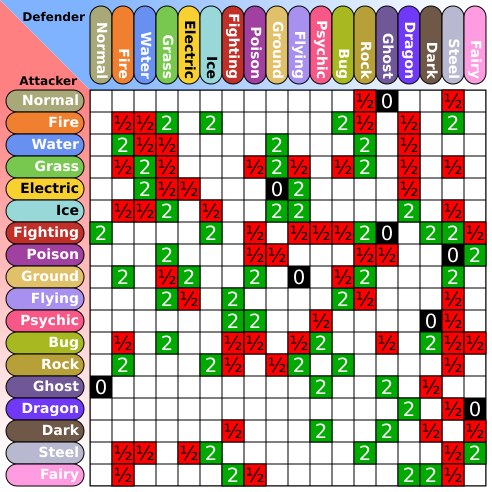</div>

This will add the following inequality constraints to our QUBO:
```
Fire:   qGrass + qIce + qBug + qSteel < 2
Water:  qFire + qGround + qRock < 2
Grass:  ...
...
```

We can include such inequality constraints of the form
```
q0 + q1 + q2 < 2
```
by adding this term to our QUBO:
```
(q0 + q1 + q2)*(q0 + q1 + q2 - 1) 
```
This term will be 0 if `q0 + q1 + q2 == 0` or `q0 + q1 + q2 == 1`, but it will add a penalty to the total QUBO energy if `q0 + q1 + q2 >= 2`.

For an arbitrary number of qubits, the generic form of this term is
```
(q0 + q1 + q2 + q3 + ...)*(q0 + q1 + q2 + q3 + ... - 1) = q0*q0 + q0*q1 + q0*q2 + q0*q3 + ...
                                                        + q1*q0 + q1*q1 + q1*q2 + q1*q3 + ...
                                                        + q2*q0 + q2*q1 + q2*q2 + q2*q3 + ...
                                                        + q3*q0 + q3*q1 + q3*q2 + q3*q3 + ...
                                                        + ...
                                                        - q0 - q1 - q2 - q3 - ...                                                       
```
Using again the tricks from above that `q0*q0 = q0` and `q0*q1 = q1*q0` etc., we find the following constraint term for "diversity"
```
                                                          2*q0*q1 + 2*q0*q2 + 2*q0*q3 + ...
                                                                  + 2*q1*q2 + 2*q1*q3 + ...
                                                                            + 2*q2*q3 + ...
                                                                                      + ...                                                        
```

### <font size="4"><span style='background:yellow'>**Final Exercise**</span></font>

Try to optimize a **balanced** Pokemon team with 6 Pokemon from all 18 types that also respects the diversity constraint as best as possible!

In [20]:
# Write your quantum computer program here:

